# FORMULA 1 RACE PREDICTION MODEL

## Predicting race winners using XGRADIENT Boost

### Background

I am a huge motorsports fan, whether Formula 1, or Indycar, or endurance racing. So as someone wanting to improve my data skills it seems natural I should try and combine this with one of my favirote hobbies. For this notebook we are going to use existing formula 1 data from kaggle and the [fastf1](https://github.com/theOehrly/Fast-F1?tab=readme-ov-file) library. The goal is to use historical car data, driver results, and other parameters to train a model to accurately predict the winner in a race. 


### The Model - XGradient Boost

When first researching this I went through several models to determine what would be the best one to use in the given scenario. Since we have many parameters, from telemetry data on cars to historical driver data, I wanted a model that could handle mutliple data sets and still provide an accurate result. Something like a simple linear regression would not be suited since we have a mixture of parameters and data types. We have numeric data, sequential data, classification data etc. Also, this is a binary classification problem since we want to predict the race winner i.e.: 1,0. 

I also wanted to choose a model that would improve over each iteration and be able to handle missing values. With those criteria in mind using XGBoost seemed to make the most sense in this scenario. Now lets see if we can use this model to predict the race winner for a given session using variuos data points gathered. 





## Step 1: import packages
For this notebook we will use numpy, pandas, sklearn, xgboost, and seaborn for visualization.

In [2]:
import numpy as np
import pandas as pd
import io
import xgboost as xgb
import urllib3
from urllib.parse import urlencode, urlparse, parse_qs, urlunparse
from urllib3 import request
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Step 2: Get the data and shape it

Now that we have imported our packages we need to:

1. Load the csv data for weather, laps, drivers, stints, and pit stops.
2. Create necessary dataframes combining data and creating necessary perofrmance indicators.


For this example we are going to start with a single race just to better understand the model before we import data.
We will use the Spa-Francochamps Grand Prix from 2024 as our training data.

We ultimately want the final data frame to look like this:

| race_id | final_position | driver_id | track_name | avg_speed | fastest_lap | number_pit_stops | avg_engine_power | avg_pit_stop_time | avg_air_temp | avg_track_temp | avg_humidity |
|---------|---------------|-----------|------------|-----------|-------------|------------------|------------------|------------------|--------------|--------------|-------------|
|         |               |           |            |           |             |                  |                  |                  |              |              |             |


Once we have the data shaped then we can then start to define our training data and test data. 

To get the data there are several options:

1. Use data from [Kaggle](https://www.kaggle.com/)
2. Use an open source api [OpenF1](https://openf1.org/)

After further research I found some issues with option 1. Though Kaggle offers some pretty extensive CSV data sets for f1 historical data, its very limited in terms of telemetry data, weather and track conditions, and other important data. As a result, I think it would be best to use the openf1 API. The good news is that instead of using the generic JSON response the API allows us to use a search param csv?=True so that we can download as a csv file in our notebook.

In [5]:
# define our http pool manager
http = urllib3.PoolManager()

#define a function that allows us to stream the data from openf1 and perform calculations on larger data sets
def stream_data_for_calcs(http_data, chunk_size: int, avg_columns: list = None, *args) -> pd.DataFrame:
    if 'calculate_avg' in args:
        sum_columns = {col: 0 for col in avg_columns}
        count_columns = {col: 0 for col in avg_columns}

        # Process data in chunks so that we do not get failed api requests
        for chunk in pd.read_csv(io.StringIO(http_data.data.decode('utf-8')), chunksize=chunk_size):
            for col in avg_columns:
                if col in chunk.columns:
                    sum_columns[col] += chunk[col].sum()
                    count_columns[col] += chunk[col].count()

        # Compute final averages for each avg column provided
        avg_values = {f"avg_{col}": (sum_columns[col] / count_columns[col]) if count_columns[col] > 0 else 0 for col in avg_columns}

        df = pd.read_csv(io.StringIO(http_data.data.decode('utf-8')))
        # Insert into dataframe the new avg_columns
        for col, avg_value in avg_values.items():
            df[col] = avg_value

        return df
        

# define a function that allows us to update a url based on data from previous dataframes
def update_url_params(url:str, query_params:dict = None) -> str:

    initial_url = urlparse(url)
    current_params = parse_qs(initial_url.query)
    current_params.update(query_params)

    final_queries = urlencode(current_params, doseq=True)
    return urlunparse(initial_url._replace(query=final_queries))
    
# define a function that intakes url and returns in csv format
def get_data(url: str, add_params: dict, stream_data:bool = False, avg_columns: list = None, **kwargs) -> pd.DataFrame:

    if add_params:
        url = update_url_params(url, add_params)

    http_response: urllib3.http.HttpResonse = http.request('GET', url)

    if http_response.status != 200:
        raise RuntimeError(
            f"Request failed with status code {http_response.status}.\n"
            f"Response body: {http_response.data.decode('utf-8')}"
        )

    try:
        if stream_data:
             streamed_df = stream_data_for_calcs(http_response,1000, avg_columns,'calculate_avg')
             return streamed_df.rename(columns=kwargs)[list(kwargs.values())] if kwargs else streamed_df
        else:
            df = pd.read_csv(io.StringIO(http_response.data.decode('utf-8')))
           # return renamed column df else return default df
            return df.rename(columns=kwargs)[list(kwargs.values())] if kwargs else df

    except Exception as e:
        raise RuntimeError(f"❌ Failed to parse CSV data: {e}")
        
# get the race id from this api request
urls={"race_and_track":"https://api.openf1.org/v1/sessions?country_name=Belgium&session_name=Race&year=2024&csv=true", 
      "driver_ids":"https://api.openf1.org/v1/drivers?csv=true", "race_weather":"https://api.openf1.org/v1/weather?csv=true",
     "lap_data":"https://api.openf1.org/v1/laps?csv=true", "telemetry_data":"https://api.openf1.org/v1/car_data?csv=true", "pit_stop_data":
      "https://api.openf1.org/v1/pit?csv=true", "results":"https://api.openf1.org/v1/position?csv=true"}

#get track data for race_id and track name
track = get_data(urls["race_and_track"], add_params={}, session_key="race_id", location="track")
#print out the dataframe for track info
track
#now we can get the weather data for that race

,race_id,track
0,9574,Spa-Francorchamps


Next we want to get some pertinent weather data such as the average air temperature, average track temperature, and other weather data that could be useful for predictions of driver performance.


In [6]:
#get weather query
session_key = track["race_id"]
track_weather = get_data(urls["race_weather"], add_params={"session_key":session_key})
#track_weather
#get average air_temperature, avg_track_temp, avg_humidity
track_weather = track_weather.assign(
    avg_air_temp=track_weather["air_temperature"].mean(),
    avg_track_temp=track_weather["track_temperature"].mean(),
    avg_humidity=track_weather["humidity"].mean())
track_weather_final = track_weather[["avg_air_temp","avg_track_temp","avg_humidity"]].iloc[:1]
#final weather dataframe
track_weather_final

#combine weather and track info

track_data_frame = track.merge(track_weather_final, how="cross")
track_data_frame

,race_id,track,avg_air_temp,avg_track_temp,avg_humidity
0,9574,Spa-Francorchamps,21.327407,42.257778,49.622222


Great, now we have basic track data including weather! Next we need to start collecting our driver data.

In [7]:
#Now that we have our track data we can make an api request to get all the drivers that were in that specific race
session_key = track["race_id"]
drivers_df = get_data(urls["driver_ids"],add_params={"session_key": session_key}, driver_number="driver_id", broadcast_name="driver_name", team_name="team_name")

#final driver dataframe
final_df = drivers_df.merge(track_data_frame, how="cross")
final_df


,driver_id,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity
0,1,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
1,2,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
2,3,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
3,4,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
4,10,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
5,11,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
6,14,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
7,16,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
8,18,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
9,20,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222


The next step is to combine these two data frames so we have an inital dataframe we can use to add average performances, weather, and other data.
First lets get the telemetry data for each driver during the race. For this we want to calculate:

1. Average speed (km/h)
2. Fastest lap (seconds)


In [8]:
# get driver numbers
driver_numbers = set(drivers_df['driver_id'])

# iterate through each driver and calculate their average lap time
lap_data = get_data(urls['lap_data'], add_params={"session_key":session_key}).rename(columns={"driver_number":"driver_id"})
avg_lap_time = lap_data.groupby("driver_id").agg(avg_lap_duration=("lap_duration","mean"), max_speed=("st_speed","max")).reset_index()

final_df_lap = avg_lap_time.merge(final_df, on="driver_id", how="right")
final_df_lap

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
5,11,110.049881,315.0,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
6,14,110.056143,317.0,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
7,16,109.205143,316.0,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
8,18,110.344707,315.0,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222
9,20,110.412634,318.0,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222


Great, now that we have the average laps and fastest speed from each driver lets add in some more granular telemetry data.This will include:
1. avg_throttle(engine power)
2. avg_rpm(revolutions per minute)


In [9]:
# since there is a large data set size (close to 30,000 rows per driver), we are going to chunk and stream the data as we calculate the 
# avg engine power and avg_rpm
#url: str, add_params: dict, stream_data:bool = False, avg_columns: list = None, **kwargs
#we will define a method that will handle the data streamed from the api and also calculate our averages per driver
all_telem_data=[]
for driver in driver_numbers:
    telemetry_data = get_data(urls["telemetry_data"],
                              add_params={"session_key":session_key, "driver_number":driver}, 
                              stream_data=True, avg_columns=["throttle","rpm"]).rename(columns={"driver_number":"driver_id"})
    avg_df = telemetry_data[["driver_id","avg_throttle","avg_rpm"]].groupby("driver_id").mean().reset_index()
    all_telem_data.append(avg_df)
concacted_telemetry_data = pd.concat(all_telem_data, ignore_index=False)
final_data_with_telem = final_df_lap.merge(concacted_telemetry_data, on="driver_id", how="left")
final_data_with_telem

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.145642,6848.276336
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.741980,7055.813200
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.373315,7035.712245
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,43.809568,7144.477350
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,47.101593,7068.449036
5,11,110.049881,315.0,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.271514,7118.456939
6,14,110.056143,317.0,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.037056,7046.875589
7,16,109.205143,316.0,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,51.991202,7074.098113
8,18,110.344707,315.0,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.570635,7053.451142
9,20,110.412634,318.0,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.726905,6960.218322


Next we need to get the number of pit stops per driver and calculate the average pit stop time in seconds. So the next data frame will return
1.pit_stops
2.avg_pit_stop_time

In [12]:
#request data for pit stops
pit_stops = get_data(urls["pit_stop_data"], add_params={"session_key":session_key}).rename(columns={"driver_number":"driver_id"})

driver_avg_pit_stops = pit_stops.groupby("driver_id").agg(avg_pit_duration=("pit_duration","mean"), pit_stops=("driver_id", "size")).reset_index()
final_data_with_pit_stops = final_data_with_telem.merge(driver_avg_pit_stops, on="driver_id", how="left")
final_data_with_pit_stops

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0
5,11,110.049881,315.0,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.271514,7118.456939,22.60,3.0
6,14,110.056143,317.0,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.037056,7046.875589,23.00,1.0
7,16,109.205143,316.0,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,51.991202,7074.098113,23.10,2.0
8,18,110.344707,315.0,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.570635,7053.451142,23.00,1.0
9,20,110.412634,318.0,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.726905,6960.218322,23.60,1.0


Finally, we can query and get the final position for each driver to determine how they finsihed the race. We will make a new column named:
1. driver_result

Once we have this data we can start setting up our model!

In [13]:
race_results = get_data(urls["results"], add_params={"session_key":session_key}).rename(columns={"driver_number":"driver_id", "position":"result"})
final_result = race_results[["driver_id","result"]].groupby("driver_id").last().reset_index()
final_data_frame = final_data_with_pit_stops.merge(final_result, on="driver_id", how="left")
final_data_frame

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops,result
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0,5
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0,19
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0,11
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0,6
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0,14
5,11,110.049881,315.0,S PEREZ,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.271514,7118.456939,22.60,3.0,8
6,14,110.056143,317.0,F ALONSO,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.037056,7046.875589,23.00,1.0,9
7,16,109.205143,316.0,C LECLERC,Ferrari,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,51.991202,7074.098113,23.10,2.0,4
8,18,110.344707,315.0,L STROLL,Aston Martin,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.570635,7053.451142,23.00,1.0,12
9,20,110.412634,318.0,K MAGNUSSEN,Haas F1 Team,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.726905,6960.218322,23.60,1.0,15


Now we have our final data set! We have some training data we can use now and we can start modeling the data.


# Step 3: Model the data

Now that we have a data set we can use we can start working with our xgboost model. We are going to use the following model with XGBOOST LambdaMART.

Why should we use XGBOOST with LambdaMART?

1. We need to use a model that can be used for ranking order, not binary classificaiton, or some other linear regression problem.
2. We have a mix of data types, numneric and categorical.
3. Xgboost allows us to use NDCG for ranking so that drivers who have better results in training data are given more weight.

Given these constraints this model seems to be a good selection to model our data. 

Now we can start to set up our training data and run the model.



In [14]:
#First, lets make sure we still have the final data_frame
final_data_frame.head()

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops,result
0,1,109.099619,319.0,M VERSTAPPEN,Red Bull Racing,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0,5
1,2,110.795643,320.0,L SARGEANT,Williams,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0,19
2,3,110.119881,316.0,D RICCIARDO,RB,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0,11
3,4,109.151667,322.0,L NORRIS,McLaren,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0,6
4,10,110.414098,324.0,P GASLY,Alpine,9574,Spa-Francorchamps,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0,14


Okay so we have our data. First, we need to encode our categorical data. In this case we need to encode the track, team_name, and driver_name so they have a numerical representation.


In [16]:
label_encoder = LabelEncoder()
final_data_frame["track"] = label_encoder.fit_transform(final_data_frame["track"])
final_data_frame["team_name"] = label_encoder.fit_transform(final_data_frame["team_name"])
final_data_frame["driver_name"] = label_encoder.fit_transform(final_data_frame["driver_name"])

final_data_frame

,driver_id,avg_lap_duration,max_speed,driver_name,team_name,race_id,track,avg_air_temp,avg_track_temp,avg_humidity,avg_throttle,avg_rpm,avg_pit_duration,pit_stops,result
0,1,109.099619,319.0,13,8,9574,0,21.327407,42.257778,49.622222,45.145642,6848.276336,23.05,2.0,5
1,2,110.795643,320.0,11,9,9574,0,21.327407,42.257778,49.622222,44.741980,7055.813200,23.45,2.0,19
2,3,110.119881,316.0,3,7,9574,0,21.327407,42.257778,49.622222,46.373315,7035.712245,22.45,2.0,11
3,4,109.151667,322.0,10,5,9574,0,21.327407,42.257778,49.622222,43.809568,7144.477350,22.60,2.0,6
4,10,110.414098,324.0,16,0,9574,0,21.327407,42.257778,49.622222,47.101593,7068.449036,22.85,2.0,14
5,11,110.049881,315.0,17,8,9574,0,21.327407,42.257778,49.622222,46.271514,7118.456939,22.60,3.0,8
6,14,110.056143,317.0,5,1,9574,0,21.327407,42.257778,49.622222,45.037056,7046.875589,23.00,1.0,9
7,16,109.205143,316.0,1,2,9574,0,21.327407,42.257778,49.622222,51.991202,7074.098113,23.10,2.0,4
8,18,110.344707,315.0,12,1,9574,0,21.327407,42.257778,49.622222,44.570635,7053.451142,23.00,1.0,12
9,20,110.412634,318.0,8,3,9574,0,21.327407,42.257778,49.622222,46.726905,6960.218322,23.60,1.0,15


Perfect, our categorical data has been properly encoded and now we can define our features and outcomes.

    driver_id  race_id  predicted_result  result
0           1     9574               3.0       5
1           2     9574              14.0      19
2           3     9574              11.0      11
3           4     9574               6.0       6
4          10     9574              14.0      14
5          11     9574               8.0       8
6          14     9574               9.0       9
7          16     9574               4.0       4
8          18     9574              12.0      12
9          20     9574              15.0      15
10         22     9574              17.0      17
11         23     9574              13.0      13
12         24     9574              20.0      20
13         27     9574              18.0      18
14         31     9574              10.0      10
15         44     9574               3.0       2
16         55     9574               7.0       7
17         63     9574               3.0       1
18         77     9574              16.0      16
19         81     95

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xticklabels'

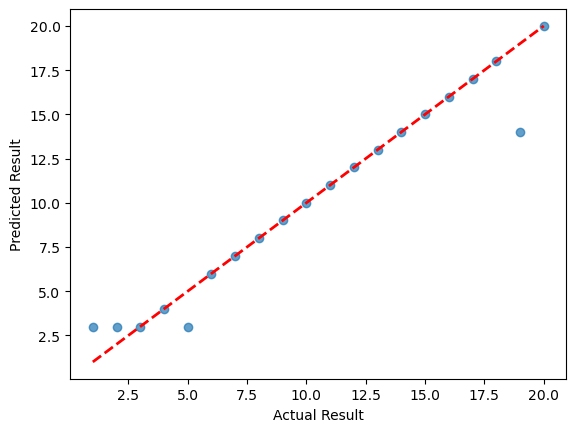

In [56]:
#these are the features we want to later have part of the DMatrix
from sklearn.preprocessing import StandardScaler

# Assuming final_data_frame is your DataFrame
# Preprocess the data
features = ["avg_lap_duration", "max_speed", "avg_air_temp", "avg_track_temp", 
            "avg_humidity", "avg_throttle", "avg_rpm", "avg_pit_duration", "pit_stops"]
X = final_data_frame[features]
y = final_data_frame["result"]

# Handle missing values
X = X.fillna(X.mean())  # or use other strategies like interpolation, etc.
y = y.fillna(y.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the XGBoost model
xg_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xg_model.fit(X_train_scaled, y_train)

# Predict for all drivers (using the full dataset)
X_scaled = scaler.transform(X)  # Scale all features for prediction
final_data_frame['predicted_result'] = np.round(xg_model.predict(X_scaled))

# Display the results
predicted_results = final_data_frame[['driver_id', 'race_id', 'predicted_result', 'result']]
print(predicted_results)

#display results
plt.scatter(final_data_frame['result'], final_data_frame['predicted_result'], alpha=0.7)
plt.plot([min(final_data_frame['result']), max(final_data_frame['result'])],
         [min(final_data_frame['result']), max(final_data_frame['result'])], 'r--', lw=2)
plt.xlabel('Actual Result')
plt.ylabel('Predicted Result')
plt.set_xticklabels(tick_labels.astype('int'))
plt.title('Actual vs Predicted Race Results')
plt.show()



